In [62]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gp

In [2]:
SAMPLE_SIZE = 10e3

In [3]:
df = pd.read_csv("data/rows.csv", 
        nrows=SAMPLE_SIZE, 
        parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"],
        infer_datetime_format=True,
        dtype={"store_and_fwd_flag": "bool"},
        true_values=["Y"],
        false_values=["N"],
)
df = df.rename(
    columns = {
        "VendorID": "vendor_id", 
        "RatecodeID": "ratecode_id",
        "PULocationID": "pickup_loc_id",
        "DOLocationID": "dropoff_loc_id"
    }
)

In [4]:
G = nx.from_pandas_edgelist(
    df, 
    source="pickup_loc_id",
    target="dropoff_loc_id",
    edge_attr=True,
    create_using=nx.DiGraph
)

In [7]:
geo = gp.read_file("data/geo_export.shp")

In [8]:
for node in G.nodes:
    try:
        G.nodes[node]['pos'] = list(geo[geo["objectid"] == node].centroid.iloc[0].coords)[0]
        G.nodes[node]['zone'] = geo[geo["objectid"] == node].zone.iloc[0]
    except:
        G.nodes[node]['pos'] = list(geo[geo["objectid"] == 1].centroid.iloc[0].coords)[0]
        G.nodes[node]['zone'] = geo[geo["objectid"] == 1].zone.iloc[0]

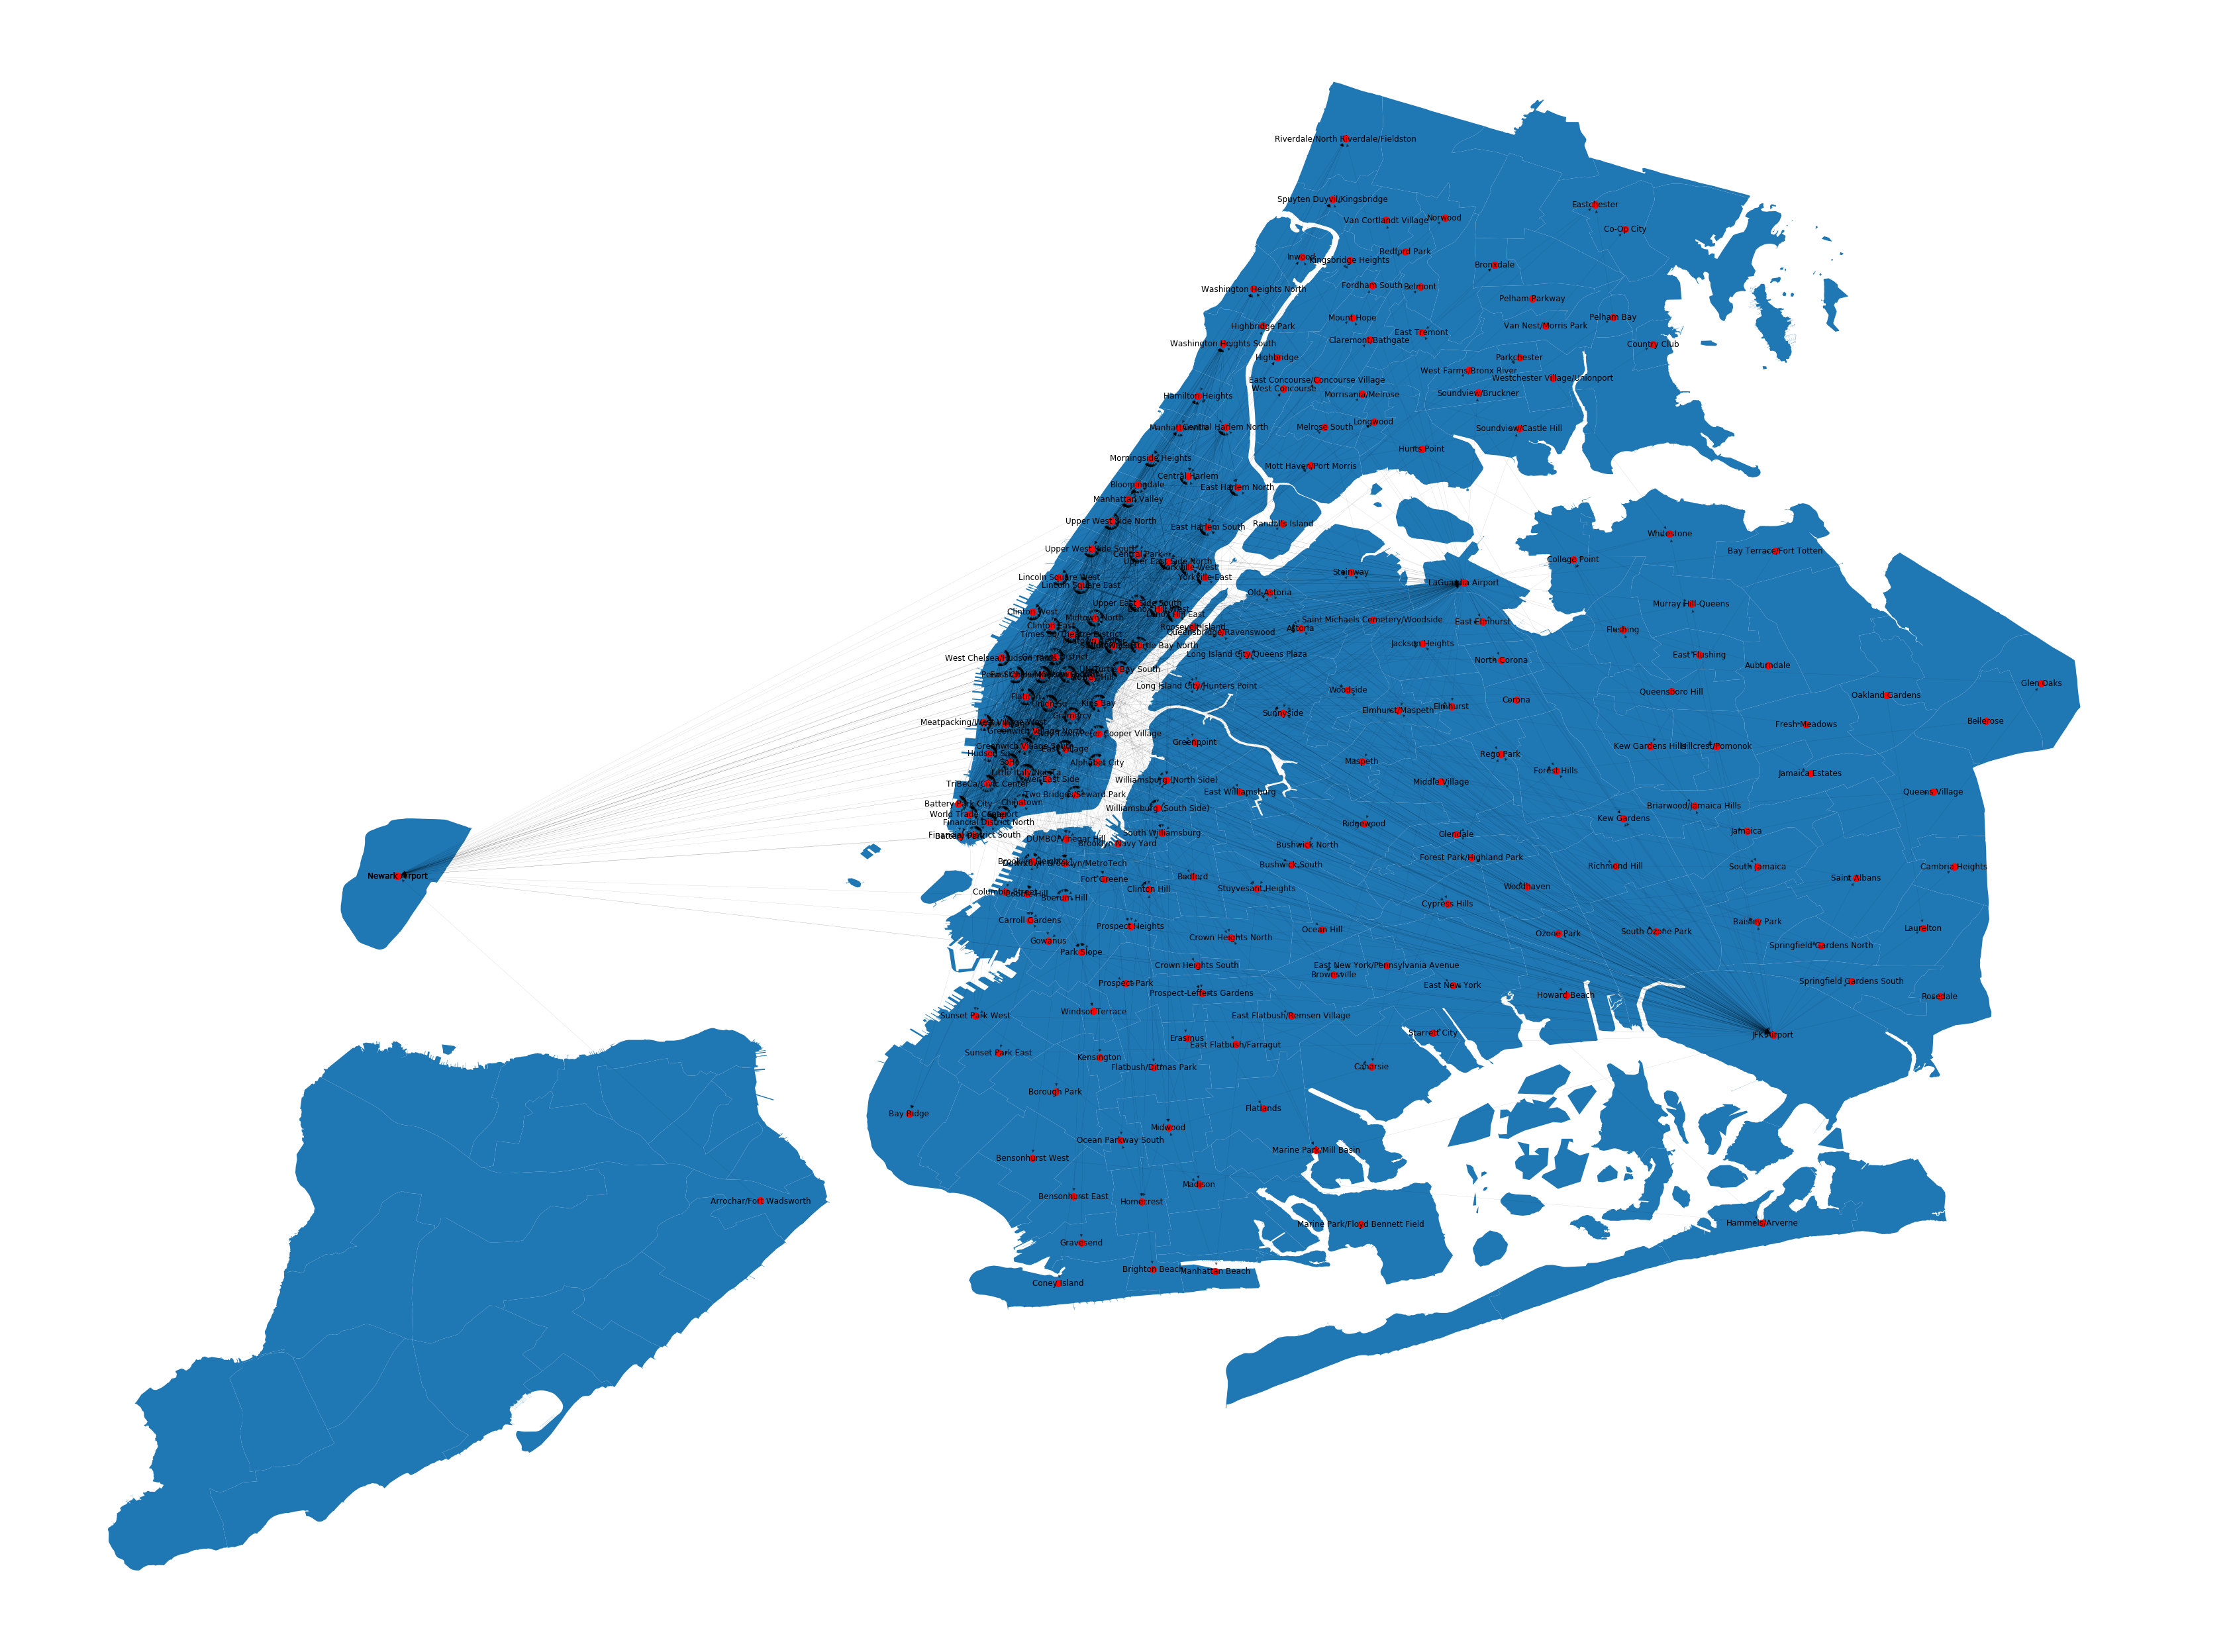

In [9]:
plt.figure(1,figsize=(60,60)) 
plt.axis('off')
nx.draw_networkx_nodes(G, nx.get_node_attributes(G, "pos"), node_size=100, node_color="red")
nx.draw_networkx_edges(G, nx.get_node_attributes(G, "pos"), alpha = 0.6, width=0.1)
nx.draw_networkx_labels(G, nx.get_node_attributes(G, "pos"), labels = nx.get_node_attributes(G, "zone"))

ax = plt.gca()
geo.plot(ax = ax)
plt.show()

In [59]:
from tqdm.notebook import trange, tqdm
import numpy as np
i = 0
from collections import defaultdict
d = defaultdict(lambda:defaultdict(np.double))

for line in tqdm(open("data/2018_Yellow_Taxi_Trip_Data.csv"), total=112234627):
    line = line[0:-1]
    csv_row = line.split(",")
    i += 1
    if i == 1:
        continue
    
    if int(csv_row[5]) == 99:
        continue
        
    d[(csv_row[7], csv_row[8])]["count"] += 1
    d[(csv_row[7], csv_row[8])]["passenger_count_sum"] += int(csv_row[3])
    d[(csv_row[7], csv_row[8])]['trip_distance_sum'] += float(csv_row[4])
    
    
    if type(d[(csv_row[7], csv_row[8])]["ratecode_count"]) is not np.ndarray:
        d[(csv_row[7], csv_row[8])]["ratecode_count"] = np.zeros(6)
    d[(csv_row[7], csv_row[8])]['ratecode_count'][int(csv_row[5])-1] += 1
    
    if type(d[(csv_row[7], csv_row[8])]["payment_type_count"]) is not np.ndarray:
        d[(csv_row[7], csv_row[8])]["payment_type_count"] = np.zeros(6)
    d[(csv_row[7], csv_row[8])]['payment_type_count'][int(csv_row[9])-1] += 1
    
    d[(csv_row[7], csv_row[8])]['fare_amount_sum'] += float(csv_row[10])
    d[(csv_row[7], csv_row[8])]['tip_amount_sum'] += float(csv_row[14])
    if float(csv_row[15]) > 0:
        d[(csv_row[7], csv_row[8])]['tolls_count'] += 1
    d[(csv_row[7], csv_row[8])]['total_amount_sum'] += float(csv_row[-1])
    if float(csv_row[-1]) > d[(csv_row[7], csv_row[8])]['total_amount_max']:
        d[(csv_row[7], csv_row[8])]['total_amount_max'] = float(csv_row[-1])
        
    if type(d[(csv_row[7], csv_row[8])]["hour_count"]) is not np.ndarray:
        d[(csv_row[7], csv_row[8])]["hour_count"] = np.zeros(24)
        
    hour = int(csv_row[1][11:13])
    if csv_row[1][-2:-1] == 'P':
        hour += 12
        if hour == 24:
            hour = 0
    d[(csv_row[7], csv_row[8])]['hour_count'][hour] += 1
    
    if type(d[(csv_row[7], csv_row[8])]["month_count"]) is not np.ndarray:
        d[(csv_row[7], csv_row[8])]["month_count"] = np.zeros(12)
    d[(csv_row[7], csv_row[8])]["month_count"][int(csv_row[1][0:2])-1] += 1  


'\n{\n    "count": 0\n    "passenger_count_sum": 0,\n    "trip_distance_sum": 0,\n    "ratecode_count": [0,0,0,0,0,0],\n    "payment_type_count": [0,0,0,0,0,0],\n    "fare_amount_sum": 0,\n    "tip_amount_sum": 0,\n    "tolls_count": 0,\n    "total_amount_sum": 0,\n    "total_amount_max": 0,\n    "total_amount_min": np.inf,\n    "hour_count": ass\'\n    "month_count": bass\n}\n'

In [140]:
df_summary = pd.DataFrame.from_dict(d, orient="index")

In [141]:
df_summary = df_summary.reset_index()

In [142]:
df_summary = df_summary.rename(
    columns={
        "level_0": "pickup_loc_id", 
        "level_1": "dropoff_loc_id"
    }
)

In [144]:
df_summary[list(map(lambda i: f"ratecode_{i}_count", range(1,7)))] = pd.DataFrame(df_summary["ratecode_count"].tolist(), index = df_summary.index, dtype = int)

In [145]:
df_summary[list(map(lambda i: f"payment_type_{i}_count", range(1,7)))] = pd.DataFrame(df_summary["payment_type_count"].tolist(), index = df_summary.index, dtype = int)

In [146]:
df_summary[list(map(lambda i: f"hour_{i}_count", range(0,24)))] = pd.DataFrame(df_summary["hour_count"].tolist(), index = df_summary.index, dtype = int)

In [147]:
df_summary[list(map(lambda i: f"month_{i}_count", range(1,13)))] = pd.DataFrame(df_summary["month_count"].tolist(), index = df_summary.index, dtype = int)

In [148]:
df_summary = df_summary.drop(columns=["ratecode_count", "payment_type_count", "hour_count", "month_count"])

In [149]:
df_summary = df_summary.fillna(0)

In [150]:
df_summary = df_summary.astype(
    {
        "pickup_loc_id": int,
        "dropoff_loc_id": int,
        "count": int,
        "passenger_count_sum": int,
        "tolls_count": int,
    }
)

In [152]:
df_summary.trip_distance_sum = df_summary.trip_distance_sum / 0.62137119

In [157]:
columns_to_round = df_summary.columns[df_summary.dtypes == np.float64]
df_summary = df_summary.round(dict(zip(columns_to_round, np.repeat(2, len(columns_to_round)))))

In [158]:
columns = ['passenger_count_', "trip_distance_", "fare_amount_", "total_amount_", "tip_amount_"]
for column in columns:
    df_summary[column + "mean"] = df_summary[column + "sum"] / df_summary["count"]

In [159]:
df_summary.to_csv("summary.csv", sep=";", index = False)